In [231]:
import sys
print(f'Interpreter dir: {sys.executable}')
import os

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    
print(f'Working dir: {os.getcwd()}')
%load_ext autoreload
%autoreload 2

Interpreter dir: /Users/jsg/Documents/GitHub/water_hackathlon/.venv_waterhack/bin/python3
Working dir: /Users/jsg/Documents/GitHub/water_hackathlon
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [232]:
import pprint
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
import seaborn as sns
import matplotlib.pyplot as plt


In [233]:
from ortools.linear_solver import pywraplp

# Run optimization as Mazzolani

---

The parameters/inuts are:
- $K$: ratio bwith Ln.
- $V_d$ or `vol_day`: average day volume at day $d$
- $V_{n,d}$ or `vol_nf`: average night flow volume at day $d$

The only variable in the original equation is then $L_n$, representing the night leakage, constant along the days. This is an assumption of the paper, which we could extend in the future.

The main formula is:

$$K \cdot V_d - K \cdot L_n + L_n = V_{n,d}$$

The first term represents the "real" day volume. The second term represents the real day leakage, plus the third term which is the leakage.

Because the system of equation (in practice) has no solution, we find the best one as follows.

Minimize $ \sum_d ( \epsilon^+_d + \epsilon^-_d)$

subject to $K \cdot V_d +(1- K) \cdot L_n  = V_{n,d} + \epsilon^+_d - \epsilon^-_d$

The constraints can be written as:

$ L_n (1- K ) - \epsilon^+_d + \epsilon^-_d = V_{n,d}  - K \cdot V_d$

Where the variables $L_n$, $\epsilon^+_d$ and $\epsilon^-_d$ are $>=0$.

---


In [253]:


def optimizeK(vol_day,vol_nf,K, debug=False):
    """Find the optimal value of leakage
    """
    # Number of data points
    N = len(vol_day)
    assert len(vol_day) == len(vol_nf), "Length of volumes do not match"
    
    # Define linear solver
    solver = pywraplp.Solver.CreateSolver('linear_programming', 'GLOP')
    
    # Create variables to be optimized
    Ln = solver.NumVar(-solver.infinity(),solver.infinity(), 'Ln')
    
    eps_pos, eps_neg = [-999]*N, [-999]*N
    for i in range(N):
        eps_pos[i] = solver.NumVar(0, solver.infinity(), f'eps_pos_{i}')
        eps_neg[i] = solver.NumVar(0,solver.infinity(), f'eps_neg_{i}')
    
    # Constraints
    constraints = [0] * N
    for i in range(N):
        c_term =  vol_nf[i] - K * vol_day[i]
        constraints[i] = solver.Constraint(c_term, c_term)
        constraints[i].SetCoefficient(eps_pos[i], -1)
        constraints[i].SetCoefficient(eps_neg[i], 1)
        constraints[i].SetCoefficient(Ln, (1-K))

    # Objective function: sum(eps)
    objective = solver.Objective()
    for i in range(N):              
        objective.SetCoefficient(eps_pos[i], 1)
        objective.SetCoefficient(eps_neg[i], 1)
    objective.SetMinimization()

    # Solve the system.
    solved = solver.Solve()
    if solved == solver.OPTIMAL:
        result_status = 'optimal'
    elif solved == solver.INFEASIBLE:
        result_status = 'No solution found'
    elif solved == solver.POSSIBLE_OVERFLOW:
        result_status = 'Integer overflow'
    else:
        result_status = solver.POSSIBLE_OVERFLOW

    # [START print_solution]
    # The value of each variable in the solution.
    eps_pos_sol = [-999]*N
    eps_neg_sol = [-999]*N
    for i in range(N):
        eps_pos_sol[i] = eps_pos[i].solution_value()
        eps_neg_sol[i] = eps_neg[i].solution_value()
    
    # The objective value of the solution.
    obj_value = np.sum(eps_pos_sol) + np.sum(eps_neg_sol)
    
    if debug:
        print('MODEL FORMULATION:\n-----')
        print(solver.ExportModelAsLpFormat(False))
        print('----')
        
    
    return {'Ln':Ln.solution_value(),
            'eps_pos_sol' : eps_pos_sol,
            'eps_neg_sol': eps_neg_sol,
            'obj_value':obj_value,
            'result_status':result_status,
            'n_var': solver.NumVariables(),
            'n_const':solver.NumConstraints()
           }

In [254]:
vol_day = [10,20,30]
vol_nf = [1,2,3]
K=0.2
sol = optimizeK(vol_day,vol_nf,K, debug=True)
pprint.pprint(sol, width=1)


MODEL FORMULATION:
-----
\ Generated by MPModelProtoExporter
\   Name             : linear_programming
\   Format           : Free
\   Constraints      : 3
\   Variables        : 7
\     Binary         : 0
\     Integer        : 0
\     Continuous     : 7
Minimize
 Obj: +1 eps_pos_0 +1 eps_neg_0 +1 eps_pos_1 +1 eps_neg_1 +1 eps_pos_2 +1 eps_neg_2 
Subject to
 auto_c_000000000: +0.8 Ln -1 eps_pos_0 +1 eps_neg_0  = -1
 auto_c_000000001: +0.8 Ln -1 eps_pos_1 +1 eps_neg_1  = -2
 auto_c_000000002: +0.8 Ln -1 eps_pos_2 +1 eps_neg_2  = -3
Bounds
 Ln free
 0 <= eps_pos_0
 0 <= eps_neg_0
 0 <= eps_pos_1
 0 <= eps_neg_1
 0 <= eps_pos_2
 0 <= eps_neg_2
End

----
{'Ln': -2.4999999999999996,
 'eps_neg_sol': [0.9999999999999998,
                 0.0,
                 0.0],
 'eps_pos_sol': [0.0,
                 0.0,
                 1.0],
 'n_const': 3,
 'n_var': 7,
 'obj_value': 1.9999999999999998,
 'result_status': 'optimal'}


In [242]:
0.8*(-2.5)

-2.0

In [24]:
def get_ln(vol_day, vol_nf, K):
    return (vol_nf - K*vol_day)/(1-K)

def get_k(vol_day, vol_nf, Ln):
    return (vol_nf - Ln)/(vol_day - Ln)

def get_obj(vol_day, vol_nf, Ln, K):
    obj = 0
    N = len(vol_day)
    for i in range(N):
        obj += np.abs(Ln*(1-k) + K*vol_day[i] - vol_nf[i])
    return obj


N = len(vol_day)
ln_est = []
for i in range(N):
    ln_est.append(get_ln(vol_day[i], vol_nf[i], K))
    print(f"Estimated daily Ln[{i}]:{ln_est[i]}")

ln_mean = np.mean(ln_est)
print(f" Mean of estimated Ln: {ln_mean}")

# #Estimated K, check
# k_est = []
# for i in range(N):
#     k_est.append(get_k(vol_day[i], vol_nf[i], ln_est[i]))
#     print(f"Estimated daily K[{i}]:{k_est[i]}")
# k_mean = np.mean(k_est)
# print(f" Mean of estimated Ln: {k_mean}")

obj = get_obj(vol_day, vol_nf, ln_mean, K)
print(f"Obbjective function: {obj}")


Estimated daily Ln[0]:-8.0
Estimated daily Ln[1]:-16.0
Estimated daily Ln[2]:-24.0
 Mean of estimated Ln: -16.0
Obbjective function: 8.0


- Si fijamos el valor de $K$: el problema de buscar un $Ln$ se reduce a hacer la media, despues de despejar cada ecuacion por separado (ver codigo superior)
- En este caso, no necesitamos ningun tipo de optimizacion. Podemos:
    1. Buscar el valor de Ln analiticamente, haciendo la media
    2. Encontrar el valor de la funcion objetivo. Para cada dia: fijar el valor de Ln del paso anterior, y sumar los $\epsilon$

In [124]:
# i=0
# print(f"Reformulation:")
# print(f" Left hand side: {K*vol_day[i] +(1-  K)*sol['Ln']}")
# print(f" Right hand side: {vol_nf[i] + sol['eps_pos_sol'][i] - sol['eps_neg_sol'][i]}")

# print(f"Reformulation 2:")
# print(f" Left hand side: {(1-  K)*sol['Ln'] - sol['eps_pos_sol'][i] + sol['eps_neg_sol'][i] }")
# print(f" Right hand side: {vol_nf[i]- K*vol_day[i]}")

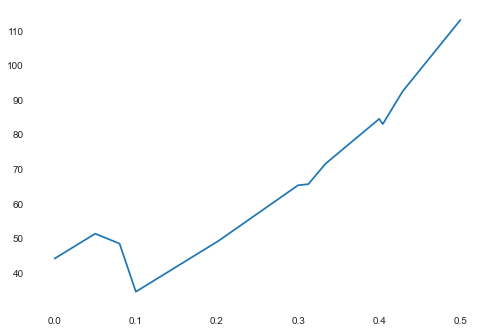

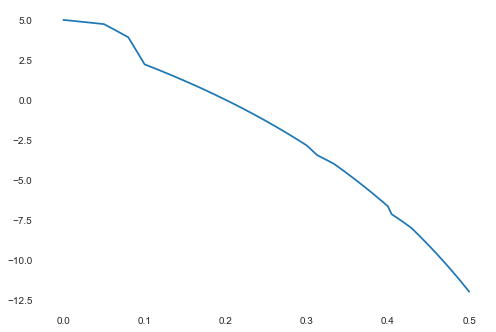

In [17]:
vol_day = [10,20,30,20,10,30,40,60,80,30,10,13,14,15]
vol_nf = [5,4,6,7,8,0,0,20,10,7,5,1,2,1]

K = np.linspace(0,0.5,1000)
X = []
Ln_all = []
for k in K:
    sol = optimizeK(vol_day,vol_nf,K=k)
    X.append(sol['obj_value'])
    Ln_all.append(sol['Ln'])
    
plt.plot(K,X)
plt.show()
plt.plot(K,Ln_all)

---
# Extension of paper

Let us formulate the problem as to find K.

The formula now changes from:

$ L_n (1- K ) - \epsilon^+_d + \epsilon^-_d = V_{n,d}  - K \cdot V_d$

to:

$ K \cdot( V_d - Ln) - \epsilon^+_d + \epsilon^-_d = V_{n,d} - Ln$



In [251]:


def optimizeK2(vol_day, vol_nf, Ln, debug=False):
    """Find the optimal value of leakage
    """
    # Number of data points
    N = len(vol_day)
    assert len(vol_day) == len(vol_nf), "Length of volumes do not match"
    
    # Define linear solver
    solver = pywraplp.Solver.CreateSolver('linear_programming', 'GLOP')
    
    # Create variables to be optimized
    K = solver.NumVar(-solver.infinity(),solver.infinity(), 'K')
    
    eps_pos, eps_neg = [-999]*N, [-999]*N
    for i in range(N):
        eps_pos[i] = solver.NumVar(0, solver.infinity(), f'eps_pos_{i}')
        eps_neg[i] = solver.NumVar(0,solver.infinity(), f'eps_neg_{i}')
    
    # Constraints
    constraints = [0] * N
    for i in range(N):
        c_term =  vol_nf[i] - Ln
        constraints[i] = solver.Constraint(c_term, c_term)
        constraints[i].SetCoefficient(eps_pos[i], -1)
        constraints[i].SetCoefficient(eps_neg[i], 1)
        constraints[i].SetCoefficient(K,  (vol_day[i] - Ln) )

    # Objective function: sum(eps)
    objective = solver.Objective()
    for i in range(N):              
        objective.SetCoefficient(eps_pos[i], 1)
        objective.SetCoefficient(eps_neg[i], 1)
    objective.SetMinimization()

    # Solve the system.
    solved = solver.Solve()
    if solved == solver.OPTIMAL:
        result_status = 'optimal'
    elif solved == solver.INFEASIBLE:
        result_status = 'No solution found'
    elif solved == solver.POSSIBLE_OVERFLOW:
        result_status = 'Integer overflow'
    else:
        result_status = solver.POSSIBLE_OVERFLOW

    # [START print_solution]
    # The value of each variable in the solution.
    eps_pos_sol = [-999]*N
    eps_neg_sol = [-999]*N
    for i in range(N):
        eps_pos_sol[i] = eps_pos[i].solution_value()
        eps_neg_sol[i] = eps_neg[i].solution_value()
    
    # The objective value of the solution.
    obj_value = np.sum(eps_pos_sol) + np.sum(eps_neg_sol)
    
    if debug:
        print('MODEL FORMULATION:\n-----')
        print(solver.ExportModelAsLpFormat(False))
        print('----')
        
    
    return {'K':K.solution_value(),
            'eps_pos_sol' : eps_pos_sol,
            'eps_neg_sol': eps_neg_sol,
            'obj_value':obj_value,
            'result_status':result_status,
            'n_var': solver.NumVariables(),
            'n_const':solver.NumConstraints()
           }

In [252]:
vol_day = [10,20,30]
vol_nf = [1,2,3]
Ln = -2.5
sol = optimizeK2(vol_day,vol_nf,Ln, debug=True)
pprint.pprint(sol, width=1)


MODEL FORMULATION:
-----
\ Generated by MPModelProtoExporter
\   Name             : linear_programming
\   Format           : Free
\   Constraints      : 3
\   Variables        : 7
\     Binary         : 0
\     Integer        : 0
\     Continuous     : 7
Minimize
 Obj: +1 eps_pos_0 +1 eps_neg_0 +1 eps_pos_1 +1 eps_neg_1 +1 eps_pos_2 +1 eps_neg_2 
Subject to
 auto_c_000000000: +12.5 K -1 eps_pos_0 +1 eps_neg_0  = 3.5
 auto_c_000000001: +22.5 K -1 eps_pos_1 +1 eps_neg_1  = 4.5
 auto_c_000000002: +32.5 K -1 eps_pos_2 +1 eps_neg_2  = 5.5
Bounds
 K free
 0 <= eps_pos_0
 0 <= eps_neg_0
 0 <= eps_pos_1
 0 <= eps_neg_1
 0 <= eps_pos_2
 0 <= eps_neg_2
End

----
{'K': 0.19999999999999998,
 'eps_neg_sol': [1.0,
                 0.0,
                 0.0],
 'eps_pos_sol': [0.0,
                 0.0,
                 1.0000000000000002],
 'n_const': 3,
 'n_var': 7,
 'obj_value': 2.0,
 'result_status': 'optimal'}


In [250]:
32.5 * 0.2

6.5

## Add K working day and holiday distinction

We take the equation above and differentiate between workin and holidays:

$ K_h \cdot( V_d - Ln) - \epsilon^+_d + \epsilon^-_d = V_{n,d} - Ln$

for $d$ that are holidays, and 

$ K_w \cdot( V_d - Ln) - \epsilon^+_d + \epsilon^-_d = V_{n,d} - Ln$

for $d$ that are working days. NOte that $L_n$ is shared in the equations above, and must be computed analitically by repeating the experiment with multiple values


### Random data

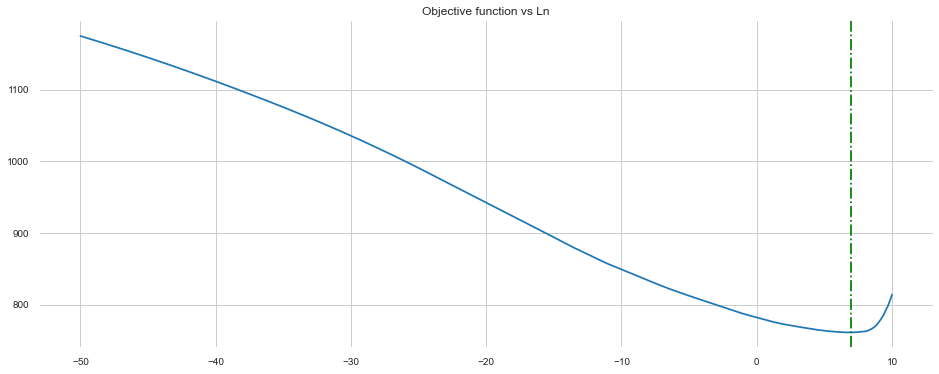

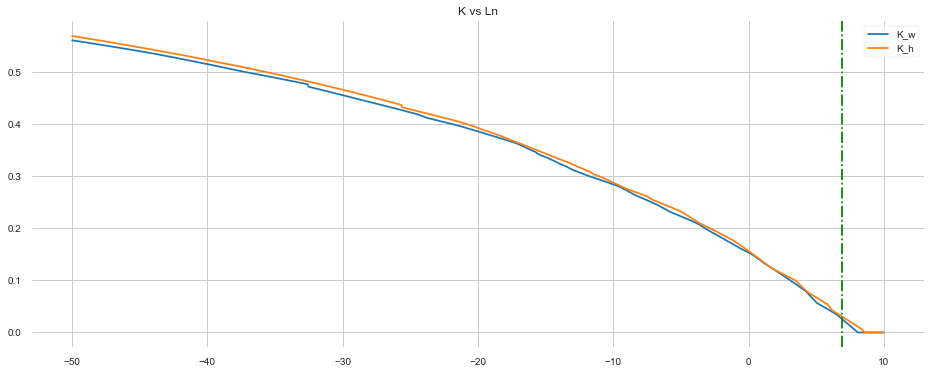

Solution:
Ln : 6.936936936936938
K_h : 0.03027318163007874
K_w : 0.025407926570527723
Obj: 761.0648224107647


In [255]:
from waterhack.mazzolani import Mazzolani

# USe random data
N = 200
is_holiday = np.random.randint(2, size=N)
vol_day = np.random.uniform(30,60,N) + 10*np.random.randint(2, size=N)
vol_nf = np.random.uniform(0,15,N)

# Initialize class
M = Mazzolani(vol_day = vol_day,
             vol_nf = vol_nf,
             is_holiday = is_holiday)

# Run optimization
Ln_list, obj, K_w, K_h,idx_sol = M.find_k(do_plot=True)

print("Solution:")
print(f"Ln : {Ln_list[idx_sol]}")
print(f"K_h : {K_h[idx_sol]}")
print(f"K_w : {K_w[idx_sol]}")
print(f"Obj: {obj[idx_sol]}")

# USe DMA data

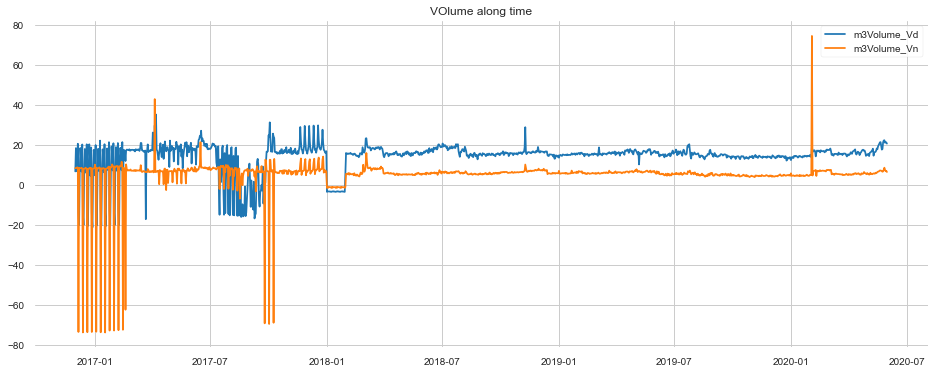

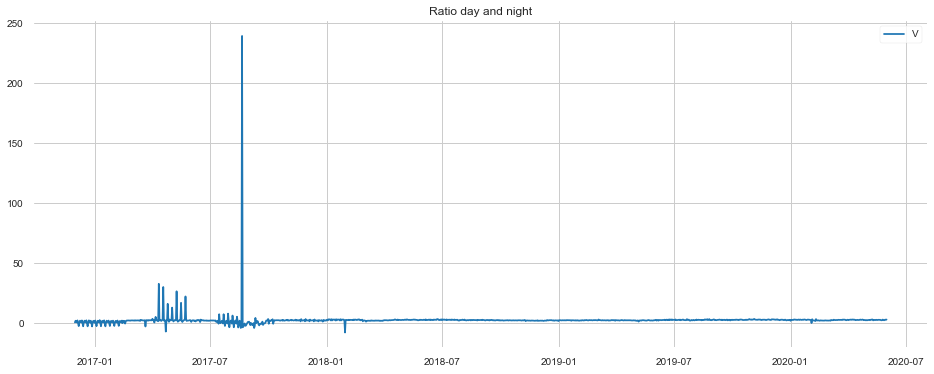

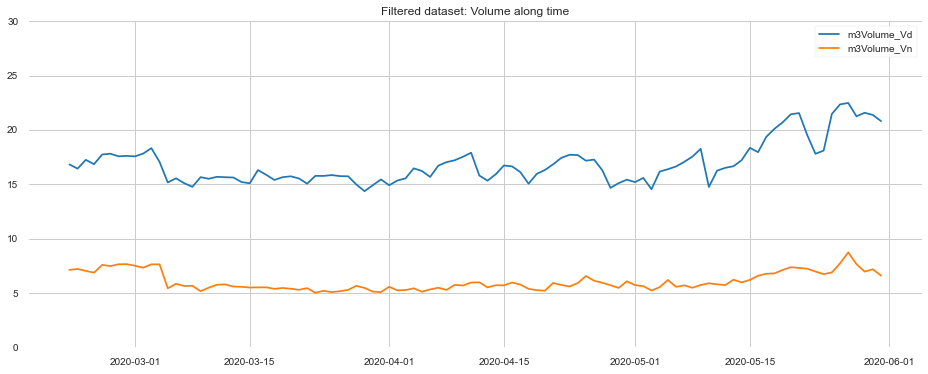

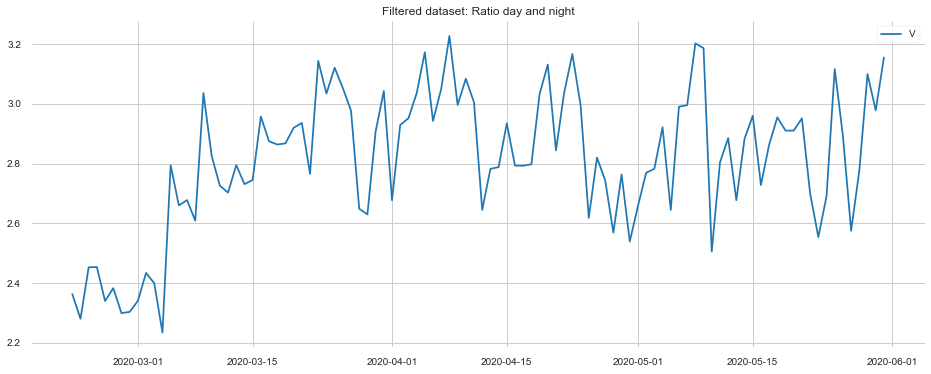

In [224]:
# Unas pruebas
from waterhack.build_features import data_load_dma
plt.rcParams['figure.figsize'] = (16.0, 6.0)

df = data_load_dma()

plt.plot(df.index, df.m3Volume_Vd)
plt.plot(df.index, df.m3Volume_Vn)
plt.legend(("m3Volume_Vd", "m3Volume_Vn"), loc="upper right")
plt.title("VOlume along time")
plt.grid()
plt.show()

plt.plot(df.index, df.m3Volume_Vd / df.m3Volume_Vn)
plt.legend(("Vd / Vn"), loc="upper right")
plt.title("Ratio day and night")
plt.grid()
plt.show()

# Lets use a subset
df_filt = df[df.m3Volume_Vd > 0].tail(100)

plt.plot(df_filt.index, df_filt.m3Volume_Vd)
plt.plot(df_filt.index, df_filt.m3Volume_Vn)
plt.legend(("m3Volume_Vd", "m3Volume_Vn"), loc="upper right")
plt.title("Filtered dataset: Volume along time")
plt.ylim(0,30)
plt.grid()
plt.show()

plt.plot(df_filt.index, df_filt.m3Volume_Vd / df_filt.m3Volume_Vn)
plt.legend(("Vd / Vn"), loc="upper right")
plt.title("Filtered dataset: Ratio day and night")
plt.grid()
plt.show()


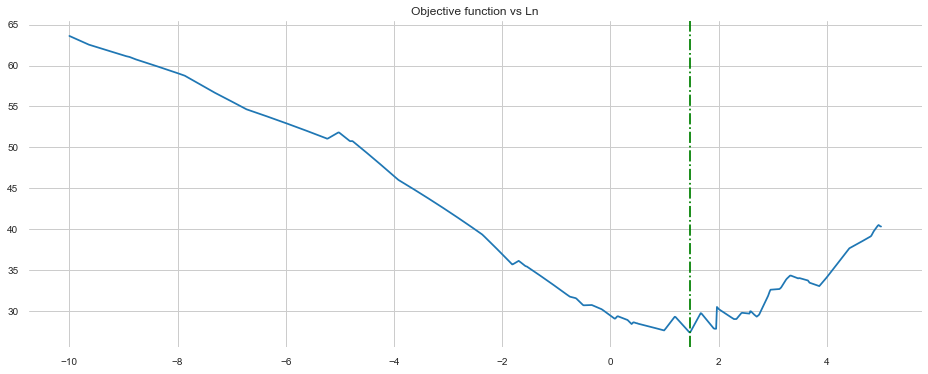

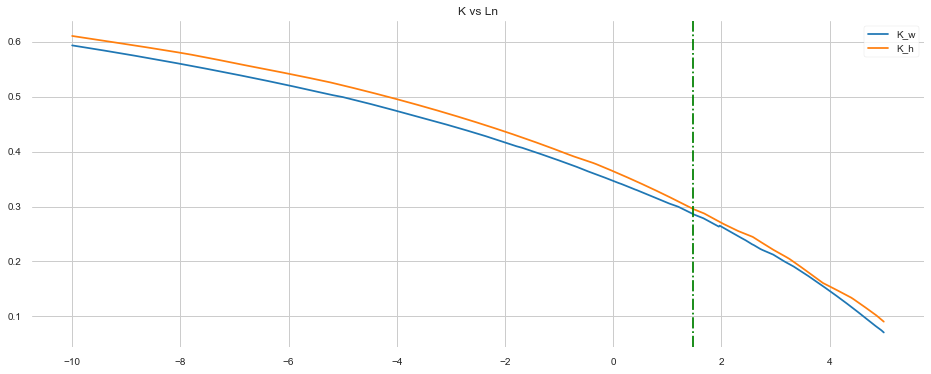

Solution:
Ln : 1.471471471471471
K_h : 0.2956861935872827
K_w : 0.28618523353279424
Obj: 27.42274826665647


In [229]:

# Initialize class
M = Mazzolani(vol_day = df_filt.m3Volume_Vd,
             vol_nf = df_filt.m3Volume_Vn,
             is_holiday = df_filt.is_holiday)

# Run optimization
Ln_list, obj, K_w, K_h,idx_sol = M.find_k(do_plot=True, ln_min = -10, ln_max=5)

print("Solution:")
print(f"Ln : {Ln_list[idx_sol]}")
print(f"K_h : {K_h[idx_sol]}")
print(f"K_w : {K_w[idx_sol]}")
print(f"Obj: {obj[idx_sol]}")

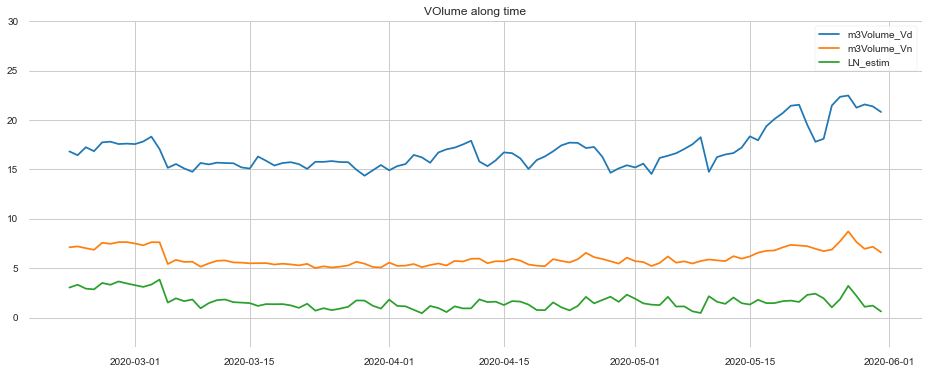

In [230]:
# Estimate daily Ln
def get_ln(vol_day, vol_nf, K):
    return (vol_nf - K*vol_day)/(1-K)

vol_day = df_filt.m3Volume_Vd.to_list()
vol_nf = df_filt.m3Volume_Vn.to_list()
is_holiday = df_filt.is_holiday.to_list()

N = len(vol_day)
ln_est = [-99]*N
for i in range(N):
    if is_holiday[i] == 1:
        ln_est[i] = get_ln(vol_day[i], vol_nf[i],K_h[idx_sol])
    else:
         ln_est[i] = get_ln(vol_day[i], vol_nf[i], K_w[idx_sol])
            
plt.plot(df_filt.index, df_filt.m3Volume_Vd)
plt.plot(df_filt.index, df_filt.m3Volume_Vn)
plt.plot(df_filt.index, ln_est)

plt.legend(("m3Volume_Vd", "m3Volume_Vn","LN_estim"), loc="upper right")
plt.title("VOlume along time")
plt.ylim(-3,30)
plt.grid()
plt.show()

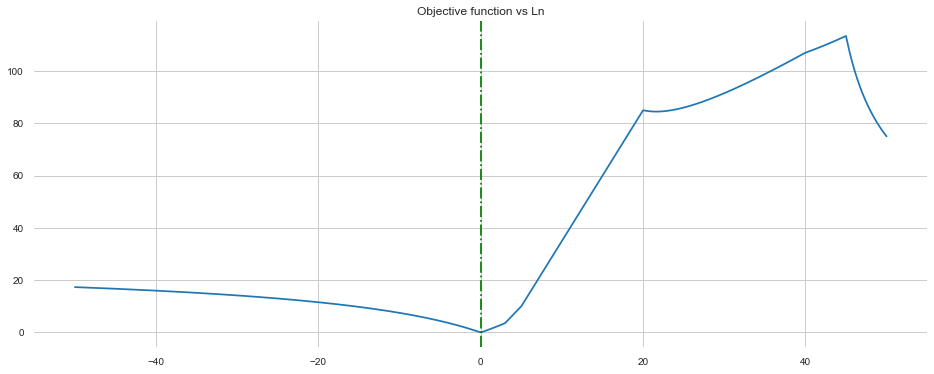

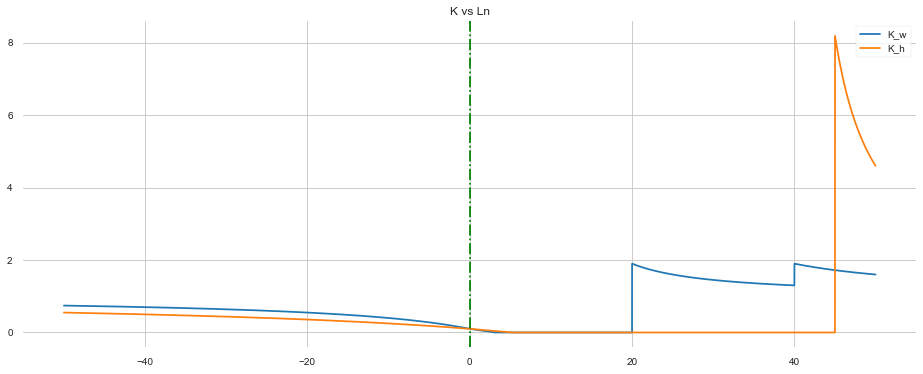

Solution:
Ln : -0.005000500050002188
K_h : 0.10008999999999994
K_w : 0.10022496625506162
Obj: 0.005399325101232108
++Ln<0 for 10 1
++Ln<0 for 20 2
++Ln<0 for 30 3
++Ln<0 for 40 4
++Ln<0 for 50 5


In [349]:
vol_day = [10,20,30,40,50]
vol_nf = [1,2,3,4,5]
is_holiday = [0,0,0,1,1]

M = Mazzolani(vol_day,
             vol_nf ,
             is_holiday)

# Run optimization
Ln_list, obj, K_w, K_h,idx_sol = M.find_k(do_plot=True, ln_min = -50, ln_max=50, n_grid=10000)

print("Solution:")
print(f"Ln : {Ln_list[idx_sol]}")
print(f"K_h : {K_h[idx_sol]}")
print(f"K_w : {K_w[idx_sol]}")
print(f"Obj: {obj[idx_sol]}")

K = 0.5
for vd,vn in zip(vol_day, vol_nf):
    if vn < K*vd:
        print(f"++Ln<0 for {vd} {vn}")
    else:
        print(f"--Ln>0 for {vd} {vn}")
    
    

# Use aggregated Smart meter data

In [262]:
df_orig = pd.read_csv('data/processed/smart_meter_night_day_V1.csv', parse_dates=['Date'])
selected_DMA = "NEWSEVMA"
df_orig = df_orig[df_orig['DMASHORTNAME'] ==selected_DMA ]
df_orig

,DMASHORTNAME,CATEGORY ID,Date,Consumption_sum_Vd,Consumption_sum_Vn,is_holiday
7,NEWSEVMA,1,2016-12-05,1503.173913,355.5,0
8,NEWSEVMA,2,2016-12-05,275.304348,52.5,0
9,NEWSEVMA,3,2016-12-05,3758.652174,590.0,0
10,NEWSEVMA,4,2016-12-05,2394.166667,607.0,0
11,NEWSEVMA,5,2016-12-05,371.652174,79.0,0
...,...,...,...,...,...,...
51470,NEWSEVMA,2,2020-07-26,610.750000,98.5,1
51471,NEWSEVMA,3,2020-07-26,8829.833333,1448.5,1
51472,NEWSEVMA,4,2020-07-26,8694.666667,1807.0,1
51473,NEWSEVMA,5,2020-07-26,929.625000,163.5,1


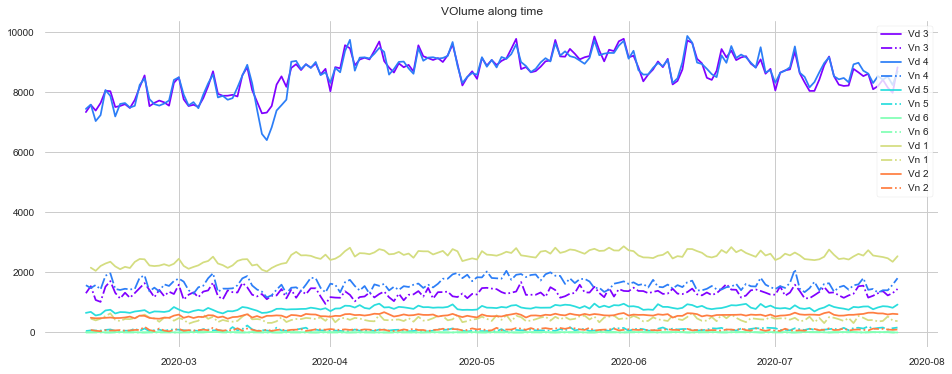

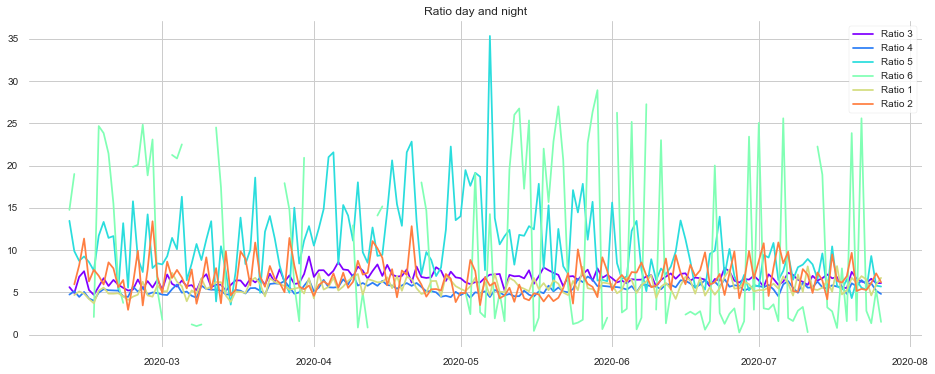

In [288]:
from matplotlib.pyplot import cm

df = df_orig.tail(1000)

ID = df['CATEGORY ID'].unique()
color = cm.rainbow(np.linspace(0,1,len(ID)+1))

for i,iid in enumerate(ID):
    df_aux = df[df['CATEGORY ID'] == iid]
    plt.plot(df_aux.Date, df_aux.Consumption_sum_Vd, color=color[i], linestyle='-', label=f'Vd {iid}')
    plt.plot(df_aux.Date, df_aux.Consumption_sum_Vn, color=color[i], linestyle='-.', label=f'Vn {iid}')
plt.legend( loc="upper right")
plt.title("VOlume along time")
plt.grid()
plt.show()

for i, iid in enumerate(ID):
    df_aux = df[df['CATEGORY ID'] == iid]
    plt.plot(df_aux.Date, df_aux.Consumption_sum_Vd / df_aux.Consumption_sum_Vn,color=color[i], label=f'Ratio {iid}')
plt.legend(loc="upper right")
plt.title("Ratio day and night")
plt.grid()
plt.show()


*** Results for CATEGORY ID = 1 ***


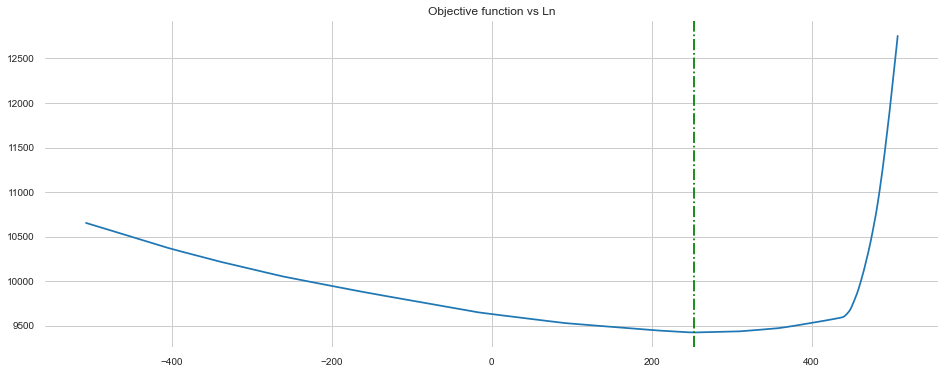

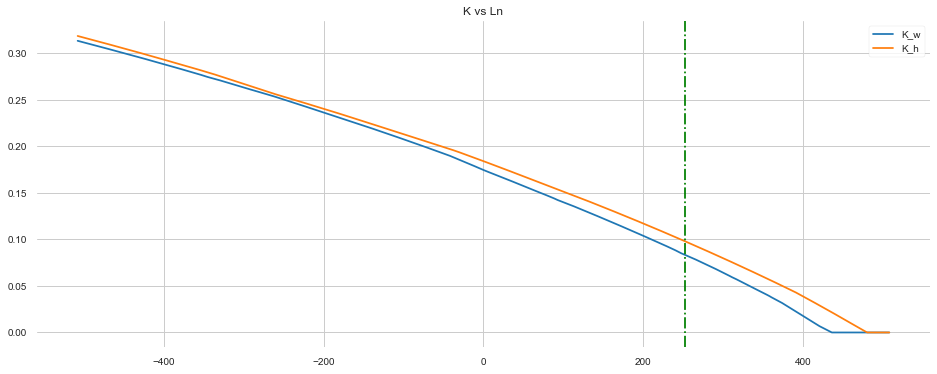

Solution:
Ln : 252.5003750937734
K_h : 0.09792009196014455
K_w : 0.08330033084840201
Obj: 9423.522832305189


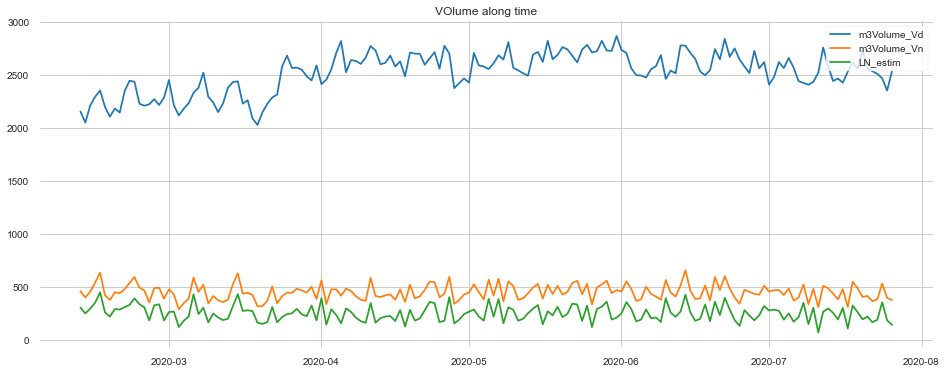

*** Results for CATEGORY ID = 2 ***


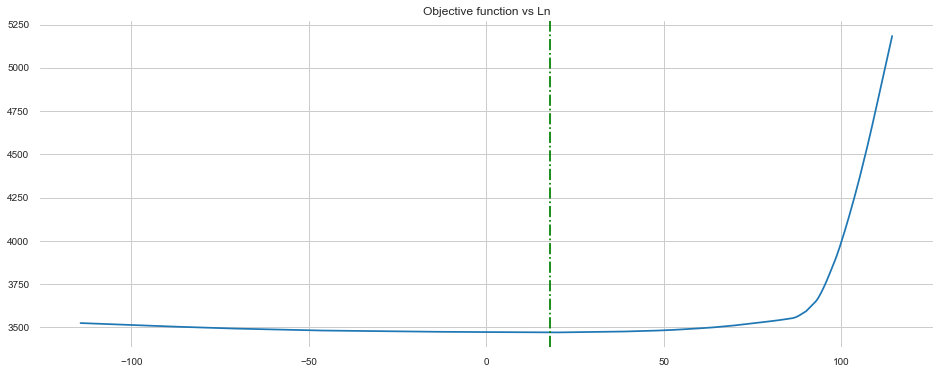

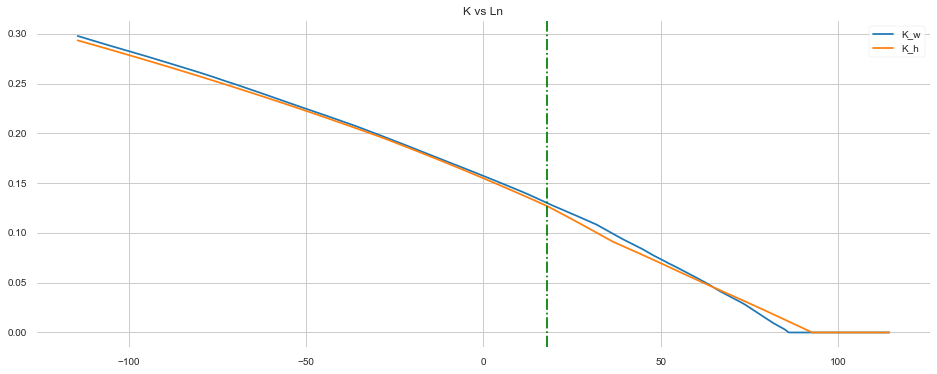

Solution:
Ln : 17.92623155788948
K_h : 0.12696914921561797
K_w : 0.1300541537226528
Obj: 3470.889418295945


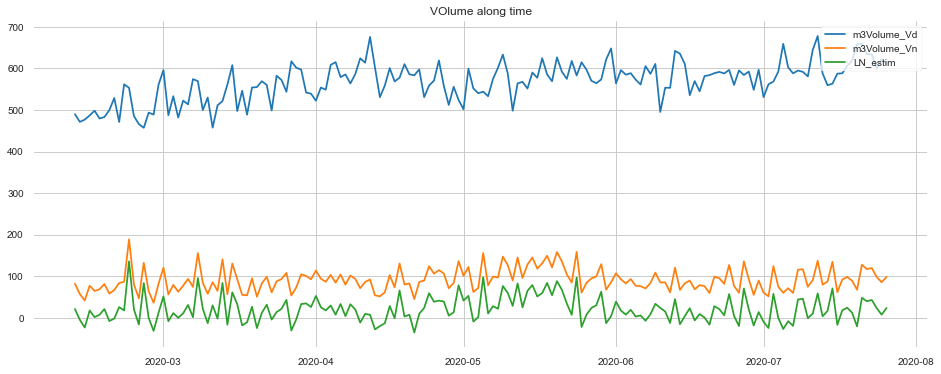

*** Results for CATEGORY ID = 3 ***


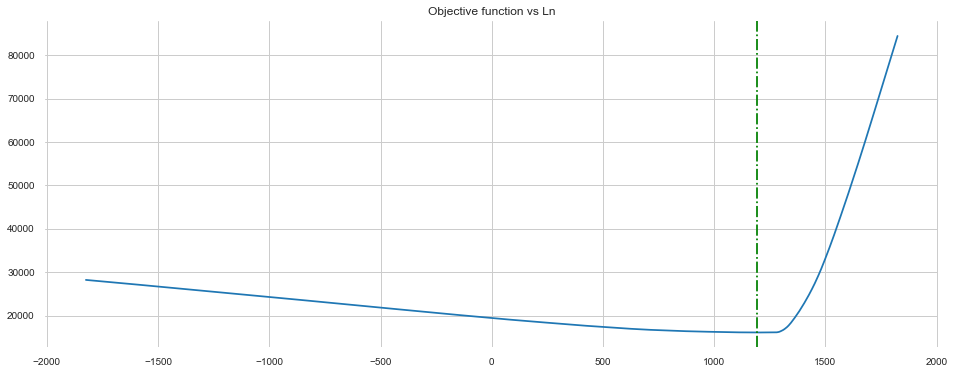

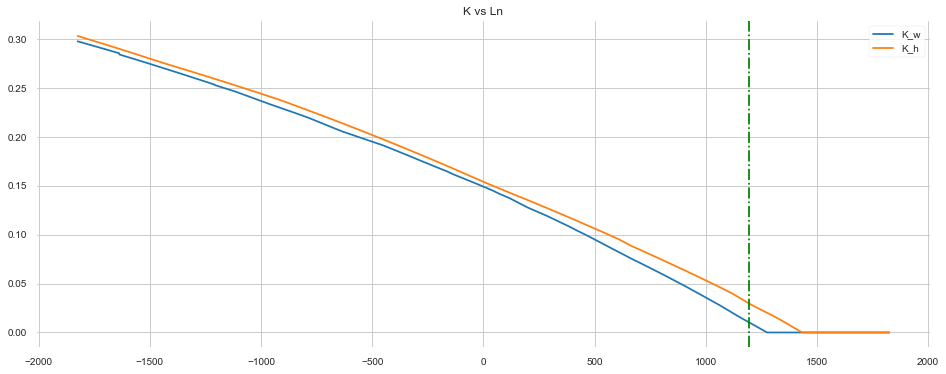

Solution:
Ln : 1194.182123655914
K_h : 0.029510344706563635
K_w : 0.01037667216642823
Obj: 16133.246957597888


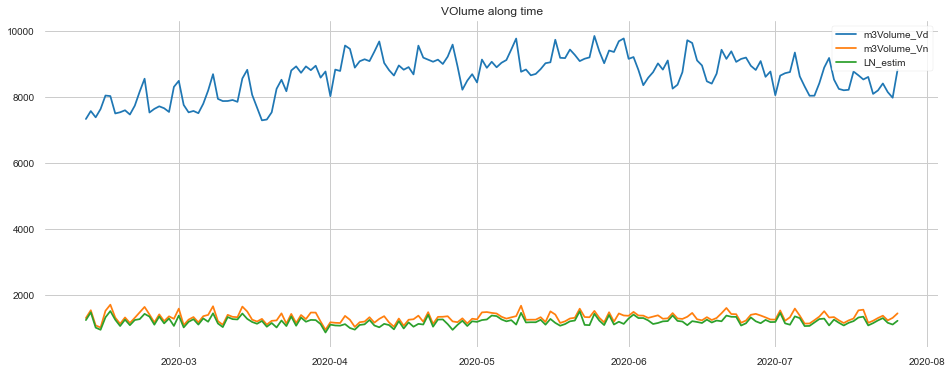

*** Results for CATEGORY ID = 4 ***


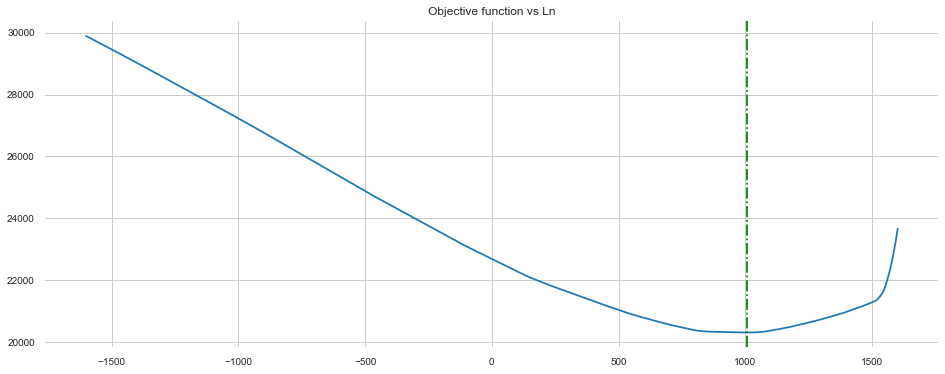

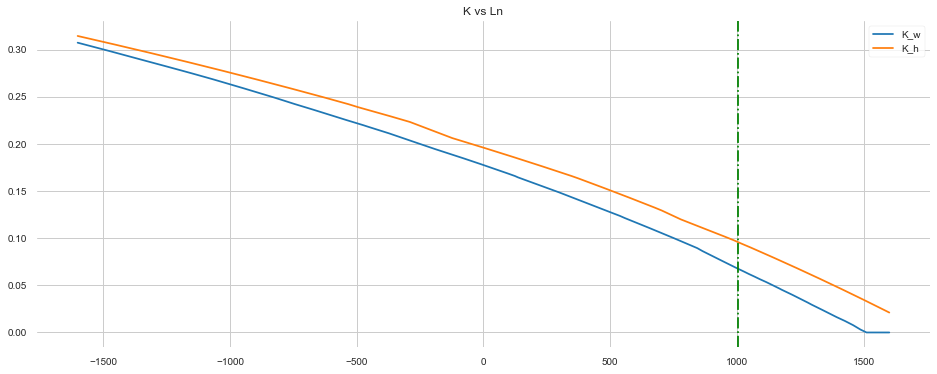

Solution:
Ln : 1006.4725243810954
K_h : 0.09555452165743852
K_w : 0.06742447943552268
Obj: 20304.951643952983


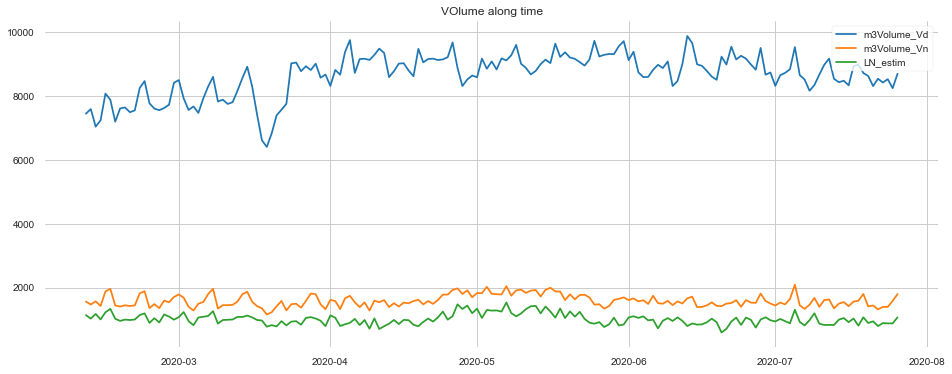

*** Results for CATEGORY ID = 5 ***


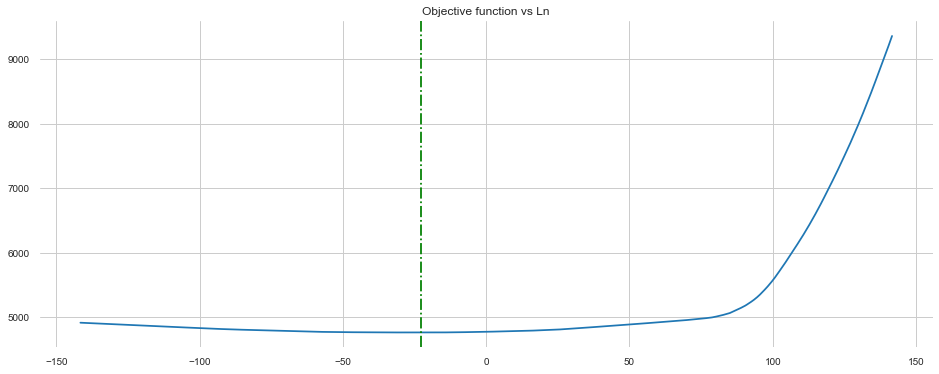

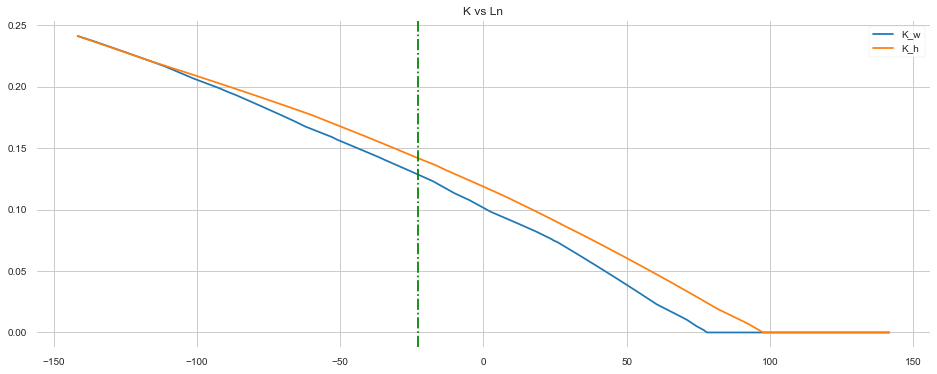

Solution:
Ln : -22.773586625823114
K_h : 0.14174543939288134
K_w : 0.12845120011374195
Obj: 4766.62445518895


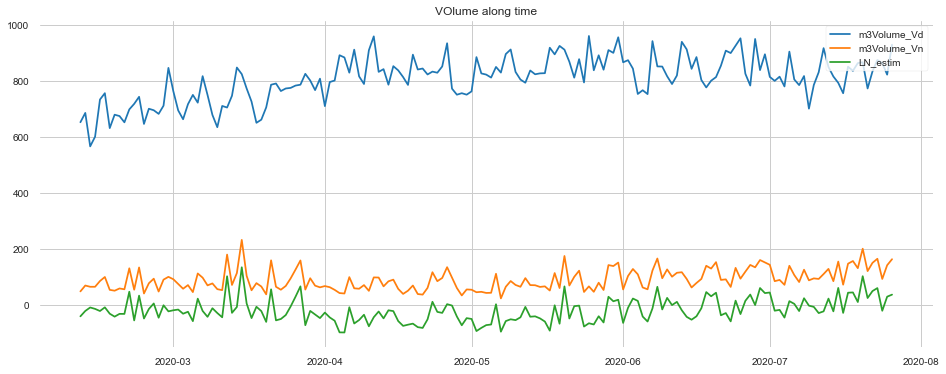

*** Results for CATEGORY ID = 6 ***


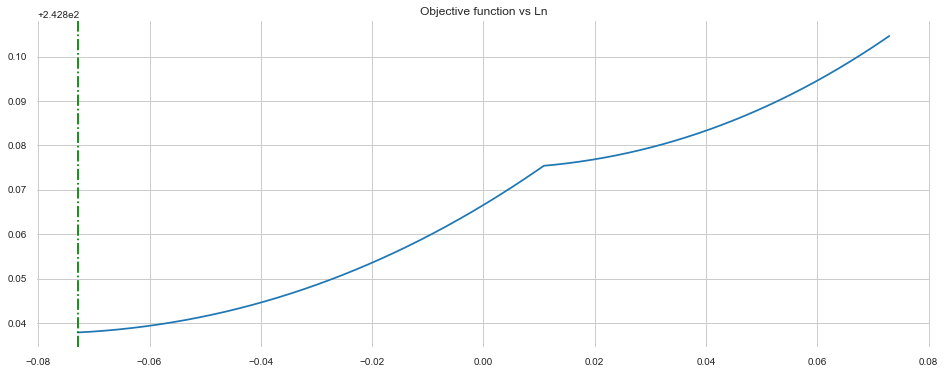

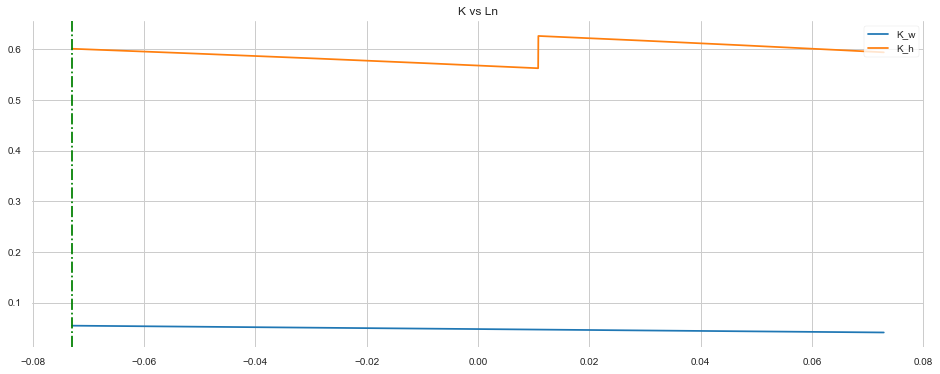

Solution:
Ln : -0.07291666666666667
K_h : 0.6012243113248797
K_w : 0.055055055055055056
Obj: 242.8379224582402


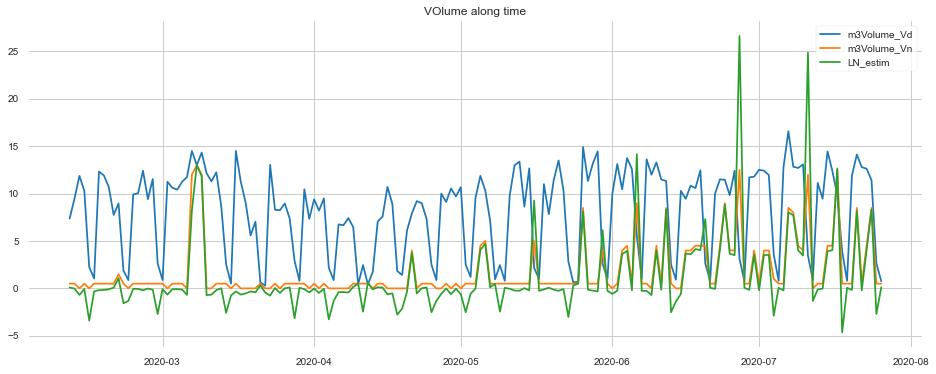

In [359]:
sol_Ln = []
so_K_w = []
sol_K_h = []
leak_rate_d = []
leak_rate_n = []

for iid in np.sort(ID):
    
    print(f"*** Results for CATEGORY ID = {iid} ***")
    df1 = df[df['CATEGORY ID'] == iid]

    # Initialize class
    vol_day = df1.Consumption_sum_Vd.to_list()
    vol_nf = df1.Consumption_sum_Vn.to_list()
    is_holiday = df1.is_holiday.to_list()

    M = Mazzolani(vol_day = vol_day,
                 vol_nf = vol_nf,
                 is_holiday = is_holiday)


    # Run optimization
    Ln_list, obj, K_w, K_h,idx_sol = M.find_k(do_plot=True, n_grid=4000)

    print("Solution:")
    print(f"Ln : {Ln_list[idx_sol]}")
    print(f"K_h : {K_h[idx_sol]}")
    print(f"K_w : {K_w[idx_sol]}")
    print(f"Obj: {obj[idx_sol]}")
    
    sol_Ln.append(Ln_list[idx_sol])
    so_K_w.append(K_h[idx_sol])
    sol_K_h.append(K_w[idx_sol])
    leak_rate_d.append( Ln_list[idx_sol] / np.mean(vol_day))
    leak_rate_n.append( Ln_list[idx_sol] / np.mean(vol_nf))
    
    # Estimate daily Ln
    def get_ln(vol_day, vol_nf, K):
        return (vol_nf - K*vol_day)/(1-K)

    N = len(vol_day)
    ln_est = [-99]*N
    for i in range(N):
        if is_holiday[i] == 1:
            ln_est[i] = get_ln(vol_day[i], vol_nf[i],K_h[idx_sol])
        else:
             ln_est[i] = get_ln(vol_day[i], vol_nf[i], K_w[idx_sol])

    plt.plot(df1.Date, vol_day)
    plt.plot(df1.Date, vol_nf)
    plt.plot(df1.Date, ln_est)

    plt.legend(("m3Volume_Vd", "m3Volume_Vn","LN_estim"), loc="upper right")
    plt.title("VOlume along time")
    # plt.ylim(-3,30)
    plt.grid()
    plt.show()

In [387]:

print(f"ID : {ID}")
print(f"sol_Ln : {np.round(sol_Ln)}")
print(f"sol_K_w : {np.round(so_K_w,3)}")
print(f"sol_K_h : {np.round(sol_K_h,3)}")
print(f"leak_rate_d : {np.round(leak_rate_d,3)}")
print(f"leak_rate_n : {np.round(leak_rate_n,3)}")

ID : [1 2 3 4 5 6]
sol_Ln : [ 253.   18. 1194. 1006.  -23.   -0.]
sol_K_w : [0.098 0.127 0.03  0.096 0.142 0.601]
sol_K_h : [0.083 0.13  0.01  0.067 0.128 0.055]
leak_rate_d : [ 0.1    0.032  0.138  0.116 -0.028 -0.009]
leak_rate_n : [ 0.557  0.195  0.905  0.628 -0.251 -0.042]


In [393]:
pd.options.display.float_format = '{:,.2f}'.format

df_sol = pd.DataFrame({"Category ID" : ID,
                  "sol_Ln" : sol_Ln,
                  "so_K_w" : so_K_w,
                  "so_K_h" : sol_K_h,
                  "leak_rate_d" : leak_rate_d
             })
print(df_sol)            

   Category ID   sol_Ln  so_K_w  so_K_h  leak_rate_d
0            1   252.50    0.10    0.08         0.10
1            2    17.93    0.13    0.13         0.03
2            3 1,194.18    0.03    0.01         0.14
3            4 1,006.47    0.10    0.07         0.12
4            5   -22.77    0.14    0.13        -0.03
5            6    -0.07    0.60    0.06        -0.01


The table above is the results of applying Mazzolani's system of equations, to the smart meter data aggregated by Category ID and DMA == NEWSEVMA. I have taken data for the past 6 months roughly. The model is optimized quickly and takes only a few seconds per category.

The mearning of the results table is:

- Category ID: socioeconomic category
- sol_ln: estimated leakage amount
- sol_K_w: ratio of (Real night flow / real day flow), during working days. Named as _K_ in the paper
- sol_K_h: same ratio but during weekends
- leak_rate_d: mean daily flow divided by sol_ln

My interpretation from the table above:

- Category ID 2 (Rising Prosperity) has the lowest leakage rates, similar pattern over weekdays and weekends
- Category ID 3 (Comfortable Communities) has the highest leakage rate, being the group with highets difference between weekday and holiday
- Category ID 1 (Affluent Achievers) and 4 (Financially Stretched) are similar: 10% and 11% leakage rates
- Category ID 5 and 6 shows the lowest estimated leakage (less than 0).
- Category ID 6 could be disregarded due to the really low inflows and weird behaviours

How could we use this in practice? As an off-line tool, it can be used to split the DMA leakage into subgroups so that the teams can focus on the right areas to fix. In future releases, more granularity can be added, for example, by groupping together houses based on coordinates.

On a daily basis, the system can run daily after 4pm and estimate the leakages per area. Alarms could be setup so that the relevant teams are warned when the leakage rates exceeds certain threshold. The system can be run via an API so that minimum implementation is needed from the company perspective.

For the reference, I post here the meaning of the categories:

```
CATEGORY ID,CATEGORY
1,"Affluent Achievers"
2,"Rising Prosperity"
3,"Comfortable Communities"
4,"Financially Stretched"
5,"Urban Adversity"
6,"Non Private Households"


GROUP ID ,GROUP                     ,CATEGORY ID
A        ,"Lavish Lifestyles"       ,1
B        ,"Executive Wealth"        ,1
C        ,"Mature Money"            ,1
D        ,"City Sophisticates"      ,2
E        ,"Career Climbers"         ,2
F        ,"Countryside Communities" ,3
G        ,"Successful Suburbs"      ,3
H        ,"Steady Neighbourhoods"   ,3
I        ,"Comfortable Seniors"     ,3
J        ,"Starting Out"            ,3
K        ,"Student Life"            ,4
L        ,"Modest Means"            ,4
M        ,"Striving Families"       ,4
N        ,"Poorer Pensioners"       ,4
O        ,"Young Hardship"          ,5
P        ,"Struggling Estates"      ,5
Q        ,"Difficult Circumstances" ,5
R        ,"Not Private Households"  ,6


```